### 데이터 로드


In [173]:
import numpy as np
import pandas as pd
# from google.colab import files
from scipy.optimize import minimize, LinearConstraint, basinhopping #최적화 패키지


In [174]:
import warnings
warnings.filterwarnings(action='ignore')

In [175]:
dividend = pd.read_excel('data.xlsx', sheet_name='dividend') # 2000년 ~ 2023년, 30개 종목의 배당금 데이터
cons12 = pd.read_excel('data.xlsx', sheet_name='cons1') #월별 배당금 제약조건 1\
tickers = cons12.T.index[2:].to_list() #tickers list
stock = pd.read_excel('data.xlsx', sheet_name='stock_price') # 2000-01-03 ~ 2023-11-28, 30개 종목의 주가 데이터
exchange = pd.read_excel('data.xlsx', sheet_name='exchange_rate') # 2000-01 ~ 2023-11, 한 달 평균 환율 데이터

In [176]:
# 데이터 전처리: 날짜 데이터 타입으로 변환
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

dividend['Ex-Dividend Date'] = pd.to_datetime(dividend['Ex-Dividend Date'])
dividend = dividend.sort_values('Ex-Dividend Date')
dividend['Month'] = dividend['Ex-Dividend Date'].apply(lambda x: x.month)  # 월 feature 추가

exchange['Date'] = pd.to_datetime(exchange['Date'])

### 백테스팅 -슬라이딩 윈도우 적용

In [177]:
##### 최적화 함수 #####

def WeightMeasure(year, investment):
    
    ### 슬라이딩 윈도우 ###
    year1String = str(year-3)
    year2String = str(year-2)
    year3String = str(year-1)
    year_n = str(year)
    
    str1 = year1String + '-01-01'
    str12 = year1String + '-12-31'
    str2 = year2String + '-01-01'
    str22 = year2String + '-12-31'
    str3 = year3String + '-01-01'
    str32 = year3String + '-12-31'
    year_now = year_n + '-01-01'
    year_end = year_n + '-12-31'

    if year == 2023:
      str32 = '2023-11-20' # 2022년은 10-28일까지만 주가 데이터가 있음

    stock_1 = stock.set_index('Date')[str1:str12] # 3년전 1년치
    stock_2 = stock.set_index('Date')[str2:str22] # 2년전 1년치
    stock_3 = stock.set_index('Date')[str3:str32] # 1년전 1년치

    stock_now = stock.set_index('Date')[year_now:year_end] #올해 값

    s1 = stock_1.pct_change().fillna(0)
    cov1 = s1[s1<0].cov()
    s2 = stock_2.pct_change().fillna(0)
    cov2 = s2[s2<0].cov()
    s3 = stock_3.pct_change().fillna(0)
    cov3 = s3[s3<0].cov()
    cov = 0.1*(cov1)+0.25*(cov2)+0.65*(cov3)

    
    #목적 함수 제약 함수 활용

    #목적 함수 Parameter 1 : 배당성장률 
    growth_rate = pd.read_excel('data.xlsx', sheet_name='growth_rate', index_col='Unnamed: 0')
    growth_rate = growth_rate.values[3]
    #목적 함수 Parameter 2 : 배당수익률
    div_rate = pd.read_excel('data.xlsx', sheet_name='div_rate',index_col='Unnamed: 0')
    div_rate = div_rate.values[0]
    #목적 함수 Parameter 3 : 무위험수익률 #미국 1년 국채 수익률
    rf = pd.read_excel('data.xlsx', sheet_name='rf')
    Rf = float(rf[rf['date'] == str3]['close'].values)/100
    
    #제약식 Parameter 1 : 내년 예상 배당금 matrix (30*12) (직전 연도 배당 테이블 * 평균배당성장률)
    cons1 = pd.read_excel('data.xlsx', sheet_name='cons1')
    cons1 = cons1[cons1['연도']==year-1].iloc[:,2:] #해당 연도의 배당금 지급
    cons1 = cons1.mul(1+growth_rate)


    if pd.to_datetime(str32) not in np.array(stock['Date']): # 12/31이 영업일이 아닐 때에는 주가 데이터가 없어서 12/30의 데이터를 확인
        str32 = year3String + '-12-30'
    elif pd.to_datetime(str32) not in np.array(stock['Date']):
        str32 = year3String + '-12-29'
    elif pd.to_datetime(str32) not in np.array(stock['Date']):
        str32 = year3String + '-12-28'
    
    price = np.array(stock[stock['Date'] == str32].iloc[0, 1:])

    def obj(x): #목적함수 구현
        
        x = np.array(x) # 결정변수 행렬 # 종목별 구매 주식 수 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] [23,46,16~~~]
        total_investment = np.dot(x, price) # 전체 투자 금액, 내적 개념, 종목수*종목가격 = 투자금액
        weights = (x*price)/total_investment # 투자 비중 / 총투자비용 : [1번종목에 총투자비용대비 얼만큼투자함, ~~~~]
       
        variance = np.dot(weights.T, np.dot(cov,weights)) # variance = sigma(wiwjcovij)
        std = np.sqrt(variance) #시그마, 표준편차 
        
        Ep = np.dot(weights,growth_rate) + np.dot(weights,div_rate*(1+growth_rate)) #기대 자본성장률 + 기대배당수익률

        result = -(Ep-Rf)/std
        
        return result

    #제약식 제약식에 해당하는 등식, 수식을 list 형식으로 모아줌, list 안에는 또 dict 형식으로 넣음)
    #1 : 주식분배금액 = 초기 투자금액
    cons = [{'type': 'eq', 'fun': lambda x: np.dot(x,price)-investment}]  # {좌변 - 우변 = 0} 투자할돈 = 들고있는 돈
    #2 : 예상 배당금을 매달 300 달러 이상!
    for i in range(0,12):                                  #1월에 들어올 배당금 >= $300
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: np.dot(x, cons1.iloc[i,:]) - 500})# cons1 =예상 배당금 matrix, cons1.iloc[i,:] --> i 월 행 뽑아내기
        #cons.append({'type': 'ineq', 'fun': lambda x: np.dot(x, cons1.iloc[i,:])-500}) 

    # boundary
    bnds = ((0,None), ) * 30
    # 임의의 초기값 : 전 종목 100개 들고 최적화 시작
    x0 = np.array([100]*30)

    #Global Minimum 찾기 / 최적화 함수에 전달되는 추가 인자들을 설정
    minimizer_kwargs = {"method":"SLSQP", "constraints":cons, "bounds":bnds}
    
    #전역 최적화를 수행하는 알고리즘으로, 특히 최적화 문제가 복잡하고 지역 최소값(local minima)에 갇힐 위험이 있는 경우에 유용합니다.
    # 이 메소드는 여러 시작점에서 로컬 최소화를 시도하여 전역 최소값(global minimum)을 찾는 방식으로 작동합니다.
    res = basinhopping(obj, x0, minimizer_kwargs=minimizer_kwargs, niter=10)
    
    '''
    obj: 최적화할 목적 함수입니다. 이 함수는 최적화 과정에서 최소화되어야 할 값을 반환합니다.
    x0: 최적화를 시작할 때 사용되는 초기 추정값입니다. 이 값은 최적화 과정에서 수정되며 최적의 해를 찾는 데 사용됩니다.
    niter=10: basinhopping 알고리즘의 반복 횟수를 설정합니다. 이 값은 알고리즘이 얼마나 많은 다른 시작점에서 최적화를 시도할지를 결정합니다
    '''
    weight = (res.x * price) / np.dot(res.x, price)  # 최적의 투자 비중
    
    '''
    tickers는 각 주식의 식별자(예: 주식의 이름 또는 코드)를 나타냅니다.
    [format(x, '.2f') for x in res.x]는 각 주식에 투자하는 수량을 소수점 두 자리까지 포맷팅하여 나타냅니다.
    ['{:.2f}%'.format(x * 100) for x in weight]는 각 주식에 대한 투자 비중을 퍼센트(%) 형태로 소수점 두 자리까지 포맷팅하여 나타냅니다.
    zip 함수는 이 세 개의 리스트(tickers, 투자 수량, 투자 비중)를 하나씩 짝지어서 각 주식에 대한 정보를 튜플 형태로 묶어 줍니다.
    ''' 
    pair = [pair for pair in zip(tickers, [format(x, '.2f') for x in res.x],)]
    total =0
    month_expect_div_list = []
    for i in range(0,12):
        i_month_expecting_div = np.dot(res.x,(cons1.iloc[i,:].values))
        month_expect_div_list.append(i_month_expecting_div)

    # 투자 종목 과 비중을 dict 형태로 보여주기
    tickers
    ticker_dictionary = {key : format(weight[i],'.2f') for i,key in enumerate(tickers)} 

    stock_now

    print("최적 투자 비중은 아래와 같습니다.")
    print(ticker_dictionary)

    variance = np.dot(weight.T, np.dot(cov,weight))
    std = np.sqrt(variance)

    df = stock_now * res.x
    df['performance']= df.sum(axis=1)
    
    return weight, std, month_expect_div_list, df

In [178]:
##### 리밸런싱 함수 #####

def Rebalancing(year, weight, investment):
    price_start = np.array(stock[stock['Date'].apply(lambda x: x.year) == year].iloc[0, 1:]) # 1월 1일 주가
    price_end = np.array(stock[stock['Date'].apply(lambda x: x.year) == year].iloc[-1, 1:]) # 해당 연도 마지막 거래 주가 
    allocation = (weight * investment) / price_start # 종목별 주식 수 list 값으로 저장
    
    div = [] #주식에 1년동안 투자시에 받을 배당금
    for ticker in tickers:
        year_div_data = dividend[dividend['Ex-Dividend Date'].apply(lambda x: x.year) == year]
        div.append(np.sum(year_div_data[year_div_data['Ticker'] == ticker]['Dividend'])) 
    
    monthly_real_div = [] # 월별 실수령 배당금 리스트 -> 생활비로 사용 가정
    for i in range(1, 13):
        #to_frame() : df 형태로 다시 세팅, reset_index() : index 새로 정의 월별 배당금 세팅
        year_div_data = dividend[dividend['Ex-Dividend Date'].apply(lambda x: x.year) == year].groupby(['Month', 'Ticker']).sum()['Dividend'].to_frame().reset_index()
        #해당 연도의 i 월 배당금 지급 금액 행 추출
        year_div_data = year_div_data[year_div_data['Month'] == i].drop('Month', axis=1).set_index('Ticker').T
        # a 리스트에 i 월의 종목별 배당금 지급금액 행을 만듬
        a = []
        for ticker in tickers:
            try: a.append(np.float(year_div_data[ticker]))  # 0에 float 취하면 오류가 생겨서 그런건지 try로 진행해야함
            except: a.append(0)
        monthly = np.dot(allocation, a) # 월별 배당금 내적(i월 배당급 지급급액*투자비중)
        monthly_real_div.append(monthly)

    actual_stock = np.dot(allocation, price_end) # 연말 포트폴리오 가치
    actual_dividend = np.dot(allocation, div) # 배당금 총합
    
    return actual_stock, actual_dividend, monthly_real_div

In [179]:
investment = 300000 # 초기 투자 금액: 30만 달러
tax_cum_d = 0 #세금 누적금액 달러
tax_cum_w = 0 #세금 누적금액 원화
div_cum_d = 0 #배당금 누적금액 달러
div_cum_w = 0 #배당금 누적금액 원화
year_temp = []
weight_temp = []
variance_temp = []
years = [y for y in range(2015, 2023)] # 백테스팅 연도 설정
years = [2021,2022,2023]
performance = pd.DataFrame(columns=tickers)


for year in years:
    weight, variance, month_expect_div_list,df = WeightMeasure(year, investment) # 최적화
    year_temp.append(year)
    weight_temp.append(weight)
    variance_temp.append(variance)
    actual_stock, actual_dividend, monthly_real_div = Rebalancing(year=year, weight=weight, investment=investment) # 1년 주기 리밸런싱
    x0 = investment
    investment = actual_stock
    x1 = actual_stock
    rate = exchange[exchange['Date'].apply(lambda x: x.year) == year]
    profit = x1 - x0 # 수익: 연말 포트폴리오 가치 - 연초 투자 금액
    
    performance = pd.concat([performance,df])

    ### 세금 계산
    if profit * rate.iloc[0, 1] > 2500000:
      tax = ((profit * rate.iloc[0, 1]) - 2500000) * 0.22 # 0.22: 해외주식 수익의 250만원을 제외한 금액에 대해 양도소득세 22% 적용
      x1 = x1 - (tax/rate.iloc[0, 1])
    else:
      tax = 0

    tax_cum_w += tax
    tax_cum_d += tax/rate.iloc[0, 1]

    print('{0}년 세전 포트폴리오 가치: ${1:.2f} / 세금: ${2:.2f} / ￦{4:.0f}\n{0}년 세후 포트폴리오 가치: ${3:.2f}'.format(year, investment, tax/rate.iloc[0, 1], x1, round(tax,-2)))
    print('{}년 세전 배당금: ${:.2f} / 세후 배당금: ${:.2f} / 배당수익률 {:.2f}% '.format(year, actual_dividend, actual_dividend*0.85,actual_dividend/x0*100))
    print('누적 세금 ${:0.2f} / ￦{:.0f}'.format(tax_cum_d,tax_cum_w))
    print('')
    
    investment = x1 # 세후 포트폴리오 가치로 재투자
        
    for i in range(0, 12):
        if year == 2023 and (i == 12 or i ==11): # 데이터 없는 2022년 11월, 12월은 패스
          continue
        else:
          print('{}월 세전 배당금: ${:.2f} / 세후 배당금: ${:.2f} / 원화 배당금 ￦{:.0f}'.format(i+1, month_expect_div_list[i], month_expect_div_list[i]*0.85,round(month_expect_div_list[i]*0.85*rate.iloc[i, 1],-3))) # 0.85: 미국 주식 배당소득세 15% 제외한 후 지급받는 배당금
          div_cum_d += month_expect_div_list[i]*0.85
          div_cum_w += month_expect_div_list[i]*0.85*rate.iloc[i, 1]
    print('누적 실질 수령 배당금 ${:.2f} ￦{:.0f}'.format(div_cum_d,div_cum_w))
    print('\n---------------------------------------------------------')

최적 투자 비중은 아래와 같습니다.
{'WBA': '0.00', 'LEG': '0.00', 'BEN': '0.00', 'SWK': '0.00', 'XOM': '0.07', 'CVX': '0.00', 'BKH': '0.00', 'NFG': '0.15', 'CAT': '0.00', 'TGT': '0.00', 'ITW': '0.00', 'EMR': '0.00', 'APD': '0.00', 'PG': '0.00', 'JNJ': '0.00', 'ATO': '0.00', 'GPC': '0.00', 'GD': '0.00', 'AOS': '0.48', 'HRL': '0.29', 'LOW': '0.00', 'PPG': '0.00', 'PH': '0.00', 'ABM': '0.00', 'ADM': '0.00', 'ABT': '0.00', 'CWT': '0.00', 'ADP': '0.00', 'TNC': '0.00', 'DOV': '0.00'}
2021년 세전 포트폴리오 가치: $425822.04 / 세금: $27217.87 / ￦32333700
2021년 세후 포트폴리오 가치: $398604.17
2021년 세전 배당금: $8590.01 / 세후 배당금: $7301.51 / 배당수익률 2.86% 
누적 세금 $27217.87 / ￦32333740

1월 세전 배당금: $1233.33 / 세후 배당금: $1048.33 / 원화 배당금 ￦1245000
2월 세전 배당금: $500.00 / 세후 배당금: $425.00 / 원화 배당금 ￦503000
3월 세전 배당금: $500.00 / 세후 배당금: $425.00 / 원화 배당금 ￦499000
4월 세전 배당금: $1233.33 / 세후 배당금: $1048.33 / 원화 배당금 ￦1241000
5월 세전 배당금: $500.00 / 세후 배당금: $425.00 / 원화 배당금 ￦492000
6월 세전 배당금: $511.44 / 세후 배당금: $434.73 / 원화 배당금 ￦501000
7월 세전 배당금: $1233.38 / 세후 배당금

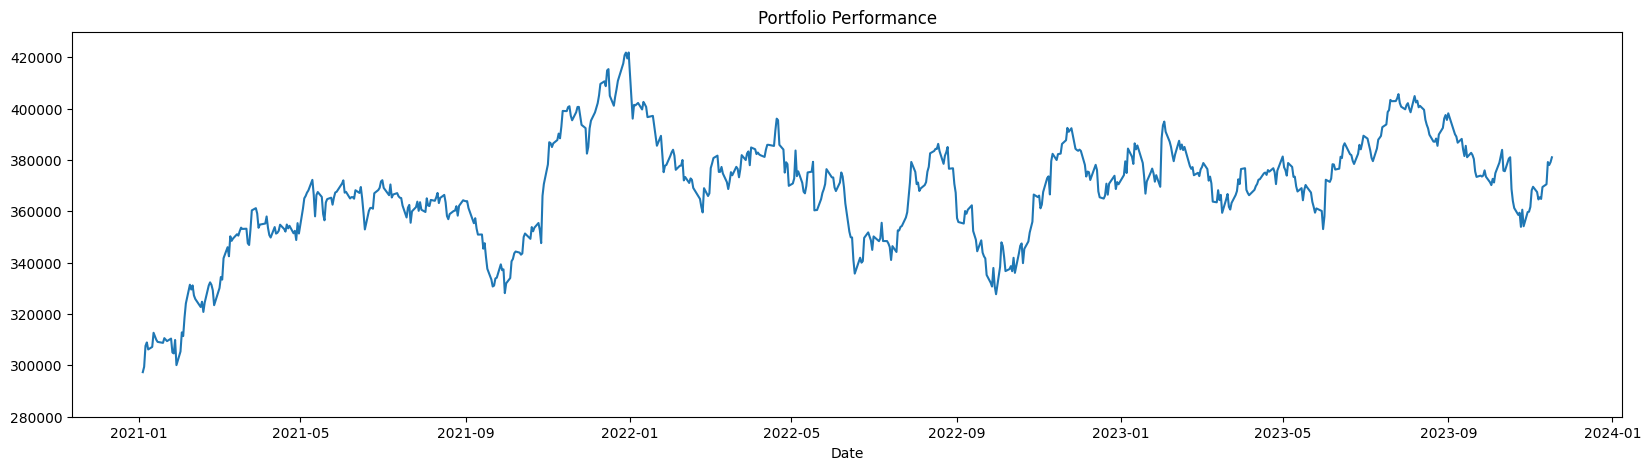

In [180]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(performance['performance'])  # 막대 그래프로 표현
plt.title('Portfolio Performance')
plt.xlabel('Date')

plt.ylim(280000, 430000)
plt.show()



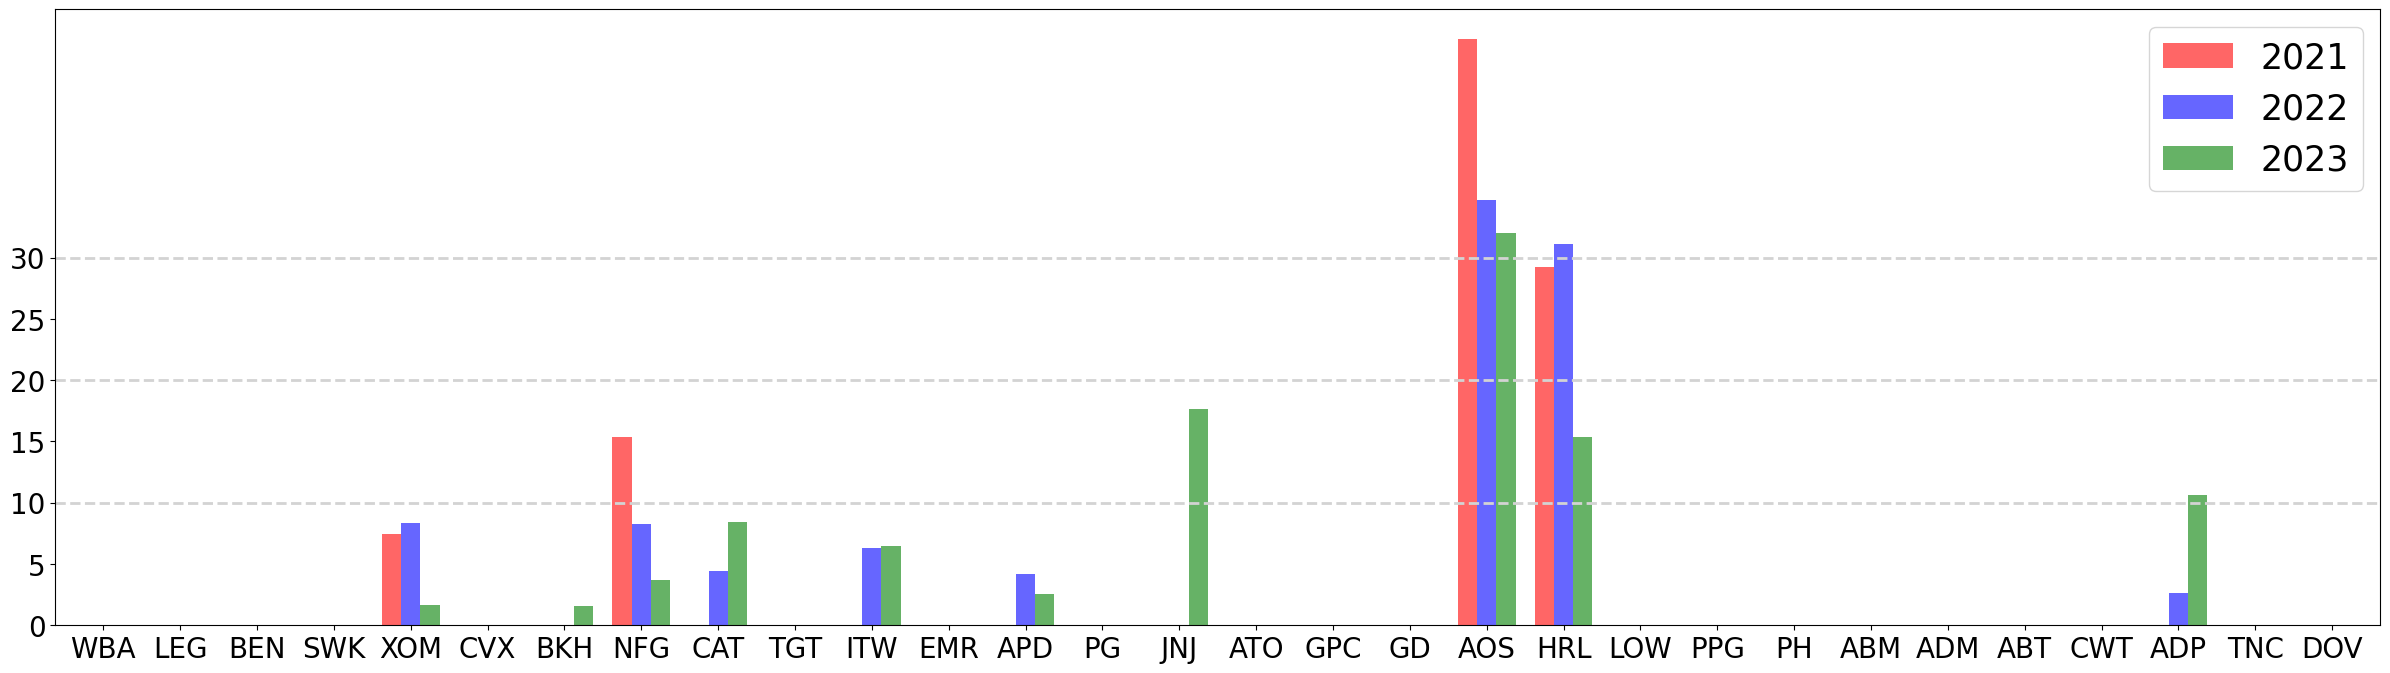

In [181]:
### 연도별 최적 투자 비중 그래프 ###
import matplotlib.pyplot as plt

weight_temp_ = []
for i in range(len(weight_temp)):
    weight_temp_.append(weight_temp[i] * 100)
    
graph = pd.DataFrame(weight_temp_, columns=tickers, index=years).T.reset_index()

graph.plot(x="index", y=years, kind="bar",color=['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan'], alpha = 0.6, width = 0.75, figsize=(30,8))
plt.axhline(10, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.axhline(20, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.axhline(30, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.xticks(np.arange(len(tickers)), tickers, rotation=0, fontsize=20)
plt.yticks(np.arange(0, 35, 5), fontsize=20)
plt.legend(fontsize=25, loc='upper right')
plt.xlabel(None)
plt.show()

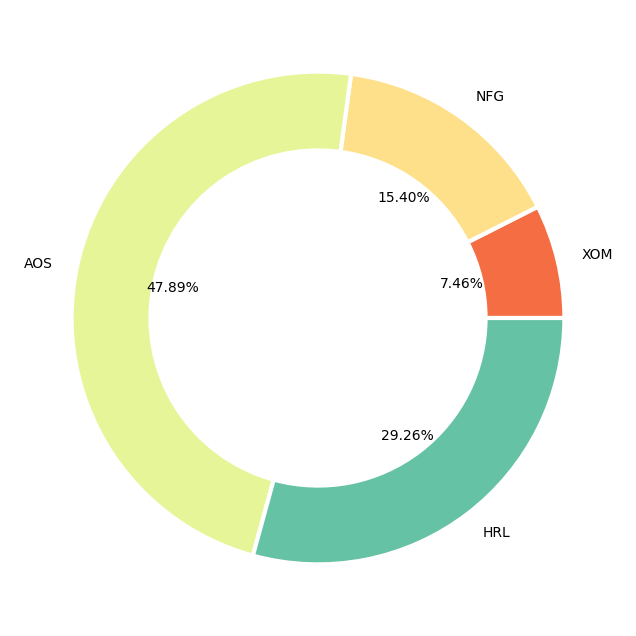

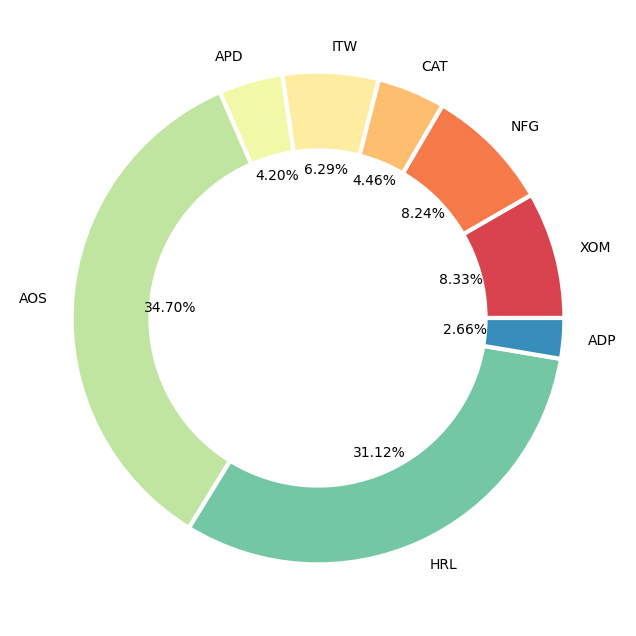

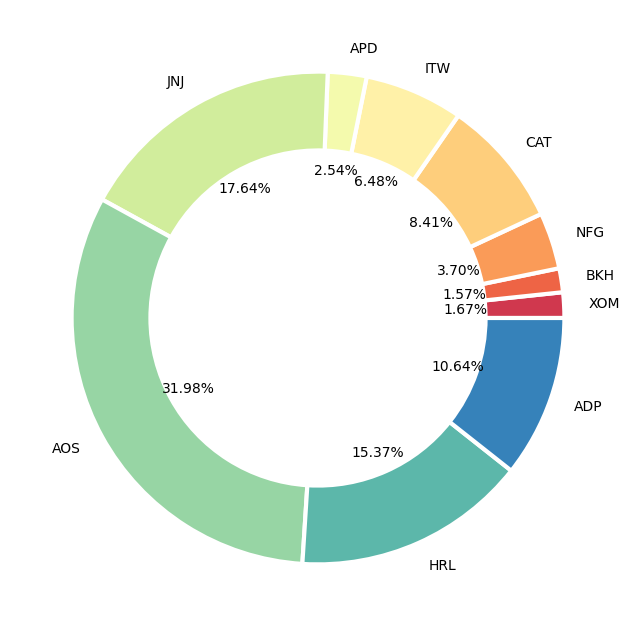

In [182]:
import seaborn as sns

for j in range(3):       
    list = []
    for i in range(30):
        if weight_temp[j][i]>0.0005:
            list.append([i,weight_temp[j][i]])
    t_list = []
    w_list = []
    for i in list:
        tic,wet = tickers[i[0]], i[1]
        t_list.append(tic)
        w_list.append(wet)

    pal = sns.color_palette('Spectral', len(t_list))

    plt.figure(figsize=(8, 8))
    wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
    plt.pie(w_list, labels=t_list, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
    plt.show()

In [184]:
soren_res = pd.read_excel('data.xlsx', sheet_name='soren_res',index_col='Date')
soren_res

,1,2,3,4,5,6,7,8,9,10,11,12,sum
Date,,,,,,,,,,,,,
2021,1233.48,500.00,500,1233.48,500.00,511.38,1233.59,500.00,511.49,1295.55,500.00,511.5,9030.47
2022,1268.23,500.00,500,1268.23,500.00,503.84,1275.03,500.00,517.07,1313.81,505.75,522.0,9173.96
2023,1187.63,517.76,500,1187.63,547.87,503.28,1203.68,547.87,515.25,1250.28,500.00,NaN,8461.25


In [189]:
print(soren_res['sum'].sum()/300000,performance['performance'].tail(1).values[0]/300000)
print(soren_res['sum'].sum()/300000+performance['performance'].tail(1).values[0]/300000)

0.0888856 1.2702394942416886
1.3591250942416886


In [185]:
soren_res*0.85

,1,2,3,4,5,6,7,8,9,10,11,12,sum
Date,,,,,,,,,,,,,
2021,1048.4580,425.000,425.0,1048.4580,425.0000,434.673,1048.5515,425.0000,434.7665,1101.2175,425.0000,434.775,7675.8995
2022,1077.9955,425.000,425.0,1077.9955,425.0000,428.264,1083.7755,425.0000,439.5095,1116.7385,429.8875,443.700,7797.8660
2023,1009.4855,440.096,425.0,1009.4855,465.6895,427.788,1023.1280,465.6895,437.9625,1062.7380,425.0000,NaN,7192.0625
